## Business Understanding

### Business Context

Agriculture remains one of the world’s most vital economic sectors, providing food, employment, and raw materials for millions of people. Globally, agriculture contributes about 4% to the world’s GDP and employs nearly 26% of the global workforce, according to the World Bank (2024). Despite this importance, crop yields are increasingly affected by climate change, soil degradation, and fluctuating input costs, posing major risks to global food security.

The need to accurately predict crop yields has therefore become critical for decision-making in agribusiness, policymaking, and food supply management. Using statistical and machine learning methods, stakeholders can forecast yields based on factors such as temperature, rainfall, soil quality, and fertilizer use. These insights help optimize resource allocation, reduce financial losses, and enhance productivity across different regions and crop types.

### Business Problem
Unpredictable weather patterns, soil degradation, and rising input costs make global crop yield forecasting unreliable. This project aims to develop a data-driven model to predict yields of the 10 most consumed crops worldwide, improving food security and agribusiness decision-making.

## Data Understanding

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
 

print("LOADING ALL DATASETS...")
print("="*50)

# Load all datasets
yield_df = pd.read_csv('data/yield_df.csv')
yield_data = pd.read_csv('data/yield.csv')
pesticides = pd.read_csv('data/pesticides.csv')
rainfall = pd.read_csv('data/rainfall.csv')
temperature = pd.read_csv('data/temp.csv')

print("📊 DATASET OVERVIEW:")
datasets = {
    'yield_df.csv': yield_df,
    'yield.csv': yield_data,
    'pesticides.csv': pesticides,
    'rainfall.csv': rainfall,
    'temp.csv': temperature
}

for name, df in datasets.items():
    print(f"\n{name}:")
    print(f"  Shape: {df.shape}")
    print(f"  Columns: {list(df.columns)}")
    print(f"  Missing values: {df.isnull().sum().sum()}")

LOADING ALL DATASETS...
📊 DATASET OVERVIEW:

yield_df.csv:
  Shape: (28242, 8)
  Columns: ['Unnamed: 0', 'Area', 'Item', 'Year', 'hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']
  Missing values: 0

yield.csv:
  Shape: (56717, 12)
  Columns: ['Domain Code', 'Domain', 'Area Code', 'Area', 'Element Code', 'Element', 'Item Code', 'Item', 'Year Code', 'Year', 'Unit', 'Value']
  Missing values: 0

pesticides.csv:
  Shape: (4349, 7)
  Columns: ['Domain', 'Area', 'Element', 'Item', 'Year', 'Unit', 'Value']
  Missing values: 0

rainfall.csv:
  Shape: (6727, 3)
  Columns: [' Area', 'Year', 'average_rain_fall_mm_per_year']
  Missing values: 774

temp.csv:
  Shape: (71311, 3)
  Columns: ['year', 'country', 'avg_temp']
  Missing values: 2547


- Explores yield_df.csv:
Shows first 3 rows
Counts unique countries
Lists unique crops
Displays year range

- Explores yield_data.csv:
Shows first 3 rows
Lists unique elements (e.g., yield, production)

- Explores pesticides.csv:
Shows first 3 rows
Explores rainfall.csv:
Shows first 3 rows

- Explores temperature.csv:
Shows first 3 rows

## Data Exploration

In [3]:
def explore_each_dataset():
    """Detailed exploration of each dataset"""
    
    print("\n🔍 DETAILED DATASET EXPLORATION")
    print("="*60)
    
    # 1. Yield DataFrame
    print("\n1. YIELD_DF.CSV:")
    print(yield_df.head(3))
    print(yield_df.info())
    print(f"Unique countries: {yield_df['Area'].nunique()}")
    print(f"Unique crops: {yield_df['Item'].unique()}")
    print(f"Year range: {yield_df['Year'].min()} - {yield_df['Year'].max()}")
    
    # 2. Yield Data
    print("\n2. YIELD.CSV:")
    print(yield_data.head(3))
    print(yield_data.info())
    print(f"Unique elements: {yield_data['Element'].unique()}")
    
    # 3. Pesticides
    print("\n3. PESTICIDES.CSV:")
    print(pesticides.info)
    print(pesticides.head(3))
    
    # 4. Rainfall
    print("\n4. RAINFALL.CSV:")

    print(rainfall.head(3))
    print(rainfall.info())
    
    # 5. Temperature
    print("\n5. TEMPERATURE.CSV:")
    print(temperature.head(3))
    print(temperature.info())

explore_each_dataset()


🔍 DETAILED DATASET EXPLORATION

1. YIELD_DF.CSV:
   Unnamed: 0     Area         Item  Year  hg/ha_yield  \
0           0  Albania        Maize  1990        36613   
1           1  Albania     Potatoes  1990        66667   
2           2  Albania  Rice, paddy  1990        23333   

   average_rain_fall_mm_per_year  pesticides_tonnes  avg_temp  
0                         1485.0              121.0     16.37  
1                         1485.0              121.0     16.37  
2                         1485.0              121.0     16.37  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     28242 non-null  int64  
 1   Area                           28242 non-null  object 
 2   Item                           28242 non-null  object 
 3   Year                           28242 non-null  i

In [4]:
def clean_individual_dataset(df, dataset_name):
    """
    Clean individual datasets by removing duplicates, missing values, and unnamed columns
    """
    print(f"\n🧹 CLEANING {dataset_name.upper()}")
    print("="*50)
    
    df_clean = df.copy()
    original_shape = df_clean.shape
    
    # 1. Remove unnamed columns
    unnamed_cols = [col for col in df_clean.columns if 'unnamed' in col.lower()]
    if unnamed_cols:
        print(f"Removing unnamed columns: {unnamed_cols}")
        df_clean = df_clean.drop(columns=unnamed_cols)
    
    # 2. Remove duplicates
    duplicates = df_clean.duplicated().sum()
    if duplicates > 0:
        print(f"Removing {duplicates} duplicate rows")
        df_clean = df_clean.drop_duplicates()
    
    # 3. Remove rows with missing values
    missing_before = df_clean.isnull().sum().sum()
    if missing_before > 0:
        print(f"Removing rows with {missing_before} missing values")
        df_clean = df_clean.dropna()
    
    # 4. Report cleaning results
    final_shape = df_clean.shape
    print(f"✅ Cleaning complete:")
    print(f"   Original: {original_shape} -> Cleaned: {final_shape}")
    print(f"   Removed {original_shape[0] - final_shape[0]} rows, {original_shape[1] - final_shape[1]} columns")
    
    return df_clean

# Load all datasets
print("📂 LOADING ALL DATASETS...")
yield_df = pd.read_csv('data/yield_df.csv')
yield_data = pd.read_csv('data/yield.csv')
pesticides = pd.read_csv('data/pesticides.csv')
rainfall = pd.read_csv('data/rainfall.csv')
temperature = pd.read_csv('data/temp.csv')

# Clean each dataset individually
cleaned_yield_df = clean_individual_dataset(yield_df, 'yield_df')
cleaned_yield_data = clean_individual_dataset(yield_data, 'yield')
cleaned_pesticides = clean_individual_dataset(pesticides, 'pesticides')
cleaned_rainfall = clean_individual_dataset(rainfall, 'rainfall')
cleaned_temperature = clean_individual_dataset(temperature, 'temperature')

📂 LOADING ALL DATASETS...

🧹 CLEANING YIELD_DF
Removing unnamed columns: ['Unnamed: 0']
Removing 2310 duplicate rows
✅ Cleaning complete:
   Original: (28242, 8) -> Cleaned: (25932, 7)
   Removed 2310 rows, 1 columns

🧹 CLEANING YIELD
✅ Cleaning complete:
   Original: (56717, 12) -> Cleaned: (56717, 12)
   Removed 0 rows, 0 columns

🧹 CLEANING PESTICIDES
✅ Cleaning complete:
   Original: (4349, 7) -> Cleaned: (4349, 7)
   Removed 0 rows, 0 columns

🧹 CLEANING RAINFALL
Removing rows with 774 missing values
✅ Cleaning complete:
   Original: (6727, 3) -> Cleaned: (5953, 3)
   Removed 774 rows, 0 columns

🧹 CLEANING TEMPERATURE
Removing 6958 duplicate rows
Removing rows with 1377 missing values
✅ Cleaning complete:
   Original: (71311, 3) -> Cleaned: (62976, 3)
   Removed 8335 rows, 0 columns


### Analyze each cleaned dataset

In [5]:
def analyze_cleaned_datasets():
    """
    Analyze the structure and content of each cleaned dataset
    """
    print("\n🔍 ANALYZING CLEANED DATASETS")
    print("="*50)
    
    datasets = {
        'yield_df': cleaned_yield_df,
        'yield': cleaned_yield_data,
        'pesticides': cleaned_pesticides,
        'rainfall': cleaned_rainfall,
        'temperature': cleaned_temperature
    }
    
    for name, df in datasets.items():
        print(f"\n📊 {name.upper()}:")
        print(f"   Shape: {df.shape}")
        print(f"   Columns: {list(df.columns)}")
        print(f"   Missing values: {df.isnull().sum().sum()}")
        print(f"   Duplicates: {df.duplicated().sum()}")
        
        # Show first 2 rows
        print(f"   Sample data:")
        print(df.head(2).to_string())
        
        # Check for common key columns
        key_columns = ['Area', 'Year', 'Item']
        available_keys = [col for col in key_columns if col in df.columns]
        if available_keys:
            print(f"   Key columns available: {available_keys}")

# Run analysis
analyze_cleaned_datasets()


🔍 ANALYZING CLEANED DATASETS

📊 YIELD_DF:
   Shape: (25932, 7)
   Columns: ['Area', 'Item', 'Year', 'hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']
   Missing values: 0
   Duplicates: 0
   Sample data:
      Area      Item  Year  hg/ha_yield  average_rain_fall_mm_per_year  pesticides_tonnes  avg_temp
0  Albania     Maize  1990        36613                         1485.0              121.0     16.37
1  Albania  Potatoes  1990        66667                         1485.0              121.0     16.37
   Key columns available: ['Area', 'Year', 'Item']

📊 YIELD:
   Shape: (56717, 12)
   Columns: ['Domain Code', 'Domain', 'Area Code', 'Area', 'Element Code', 'Element', 'Item Code', 'Item', 'Year Code', 'Year', 'Unit', 'Value']
   Missing values: 0
   Duplicates: 0
   Sample data:
  Domain Code Domain  Area Code         Area  Element Code Element  Item Code   Item  Year Code  Year   Unit  Value
0          QC  Crops          2  Afghanistan          5419   Yield

### Merging Cleaned Datasets

In [6]:
def merge_datasets_strategy(yield_df, yield_data, pesticides, rainfall, temperature):
    """
    Strategy for merging all cleaned datasets
    """
    print("\n🔗 MERGING CLEANED DATASETS")
    print("="*50)
    
    # Strategy 1: If yield_df already contains all data, use it as base
    if all(col in yield_df.columns for col in ['hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']):
        print("✅ Using yield_df as primary dataset (already contains integrated data)")
        master_df = yield_df.copy()
        
    else:
        # Strategy 2: Merge separate datasets
        print("🔄 Merging separate datasets...")
        
        # Start with yield data as base
        if 'Value' in yield_data.columns:
            master_df = yield_data.rename(columns={'Value': 'hg/ha_yield'})
        else:
            master_df = yield_df.copy()
        
        # Merge pesticides
        if 'Value' in pesticides.columns and all(col in pesticides.columns for col in ['Area', 'Year']):
            print("Merging pesticides data...")
            pesticides_clean = pesticides.rename(columns={'Value': 'pesticides_tonnes'})
            master_df = pd.merge(master_df, pesticides_clean[['Area', 'Year', 'pesticides_tonnes']], 
                               on=['Area', 'Year'], how='left', suffixes=('', '_pesticide'))
        
        # Merge rainfall
        if 'Value' in rainfall.columns and all(col in rainfall.columns for col in ['Area', 'Year']):
            print("Merging rainfall data...")
            rainfall_clean = rainfall.rename(columns={'Value': 'average_rain_fall_mm_per_year'})
            master_df = pd.merge(master_df, rainfall_clean[['Area', 'Year', 'average_rain_fall_mm_per_year']], 
                               on=['Area', 'Year'], how='left', suffixes=('', '_rainfall'))
        
        # Merge temperature
        if 'Value' in temperature.columns and all(col in temperature.columns for col in ['Area', 'Year']):
            print("Merging temperature data...")
            temperature_clean = temperature.rename(columns={'Value': 'avg_temp'})
            master_df = pd.merge(master_df, temperature_clean[['Area', 'Year', 'avg_temp']], 
                               on=['Area', 'Year'], how='left', suffixes=('', '_temp'))
    
    print(f"✅ Final merged dataset shape: {master_df.shape}")
    return master_df

# Merge all datasets
final_master_df = merge_datasets_strategy(
    cleaned_yield_df, cleaned_yield_data, cleaned_pesticides, cleaned_rainfall, cleaned_temperature
)


🔗 MERGING CLEANED DATASETS
✅ Using yield_df as primary dataset (already contains integrated data)
✅ Final merged dataset shape: (25932, 7)


### Finally Quality Check On the merged Dataset

In [10]:
def final_quality_check(df):
    """
    Comprehensive quality check on the final merged dataset
    """
    print("\n📋 FINAL QUALITY CHECK - MERGED DATASET")
    print("="*60)
    
    print(f"Dataset shape: {df.shape}")
    print(f"Total records: {len(df)}")
    
    # Check for missing values in final dataset
    print("\n🔍 Missing values in final dataset:")
    missing_data = df.isnull().sum()
    has_missing = False
    for col, missing_count in missing_data.items():
        if missing_count > 0:
            has_missing = True
            percentage = (missing_count / len(df)) * 100
            print(f"  {col}: {missing_count} missing ({percentage:.1f}%)")
    
    if not has_missing:
        print("  ✅ No missing values found!")
    
    # Check data types
    print("\n📊 Data types:")
    for col in df.columns:
        dtype = df[col].dtype
        unique_count = df[col].nunique() if df[col].dtype == 'object' else 'N/A'
        sample_value = df[col].iloc[0] if len(df) > 0 else 'N/A'
        print(f"  {col}: {dtype} (Unique: {unique_count}, Sample: {sample_value})")
    
    # Check for critical columns presence
    critical_cols = ['hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']
    available_critical = [col for col in critical_cols if col in df.columns]
    print(f"\n✅ Available critical columns: {len(available_critical)}/{len(critical_cols)}")
    print(f"   {available_critical}")
    
    return df

# Run final quality check
final_checked_df = final_quality_check(final_master_df)


📋 FINAL QUALITY CHECK - MERGED DATASET
Dataset shape: (25932, 7)
Total records: 25932

🔍 Missing values in final dataset:
  ✅ No missing values found!

📊 Data types:
  Area: object (Unique: 101, Sample: Albania)
  Item: object (Unique: 10, Sample: Maize)
  Year: int64 (Unique: N/A, Sample: 1990)
  hg/ha_yield: int64 (Unique: N/A, Sample: 36613)
  average_rain_fall_mm_per_year: float64 (Unique: N/A, Sample: 1485.0)
  pesticides_tonnes: float64 (Unique: N/A, Sample: 121.0)
  avg_temp: float64 (Unique: N/A, Sample: 16.37)

✅ Available critical columns: 4/4
   ['hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']


### Data Summary Statistics

In [11]:
def dataset_summary_statistics(df):
    """
    Provide comprehensive summary statistics for the final dataset
    """
    print("\n📈 FINAL DATASET SUMMARY STATISTICS")
    print("="*60)
    
    # Basic information
    print("1. BASIC INFORMATION:")
    print(f"   Total countries: {df['Area'].nunique() if 'Area' in df.columns else 'N/A'}")
    print(f"   Total crops: {df['Item'].nunique() if 'Item' in df.columns else 'N/A'}")
    print(f"   Year range: {df['Year'].min() if 'Year' in df.columns else 'N/A'} - {df['Year'].max() if 'Year' in df.columns else 'N/A'}")
    print(f"   Total records: {len(df)}")
    
    # Numerical columns statistics
    numerical_cols = ['hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']
    available_numerical = [col for col in numerical_cols if col in df.columns]
    
    if available_numerical:
        print("\n2. NUMERICAL FEATURES SUMMARY:")
        for col in available_numerical:
            print(f"   {col}:")
            print(f"      Min: {df[col].min():.2f}")
            print(f"      Max: {df[col].max():.2f}")
            print(f"      Mean: {df[col].mean():.2f}")
            print(f"      Median: {df[col].median():.2f}")
            print(f"      Std: {df[col].std():.2f}")
    
    # Top crops and countries
    print("\n3. DATA DISTRIBUTION:")
    if 'Item' in df.columns:
        top_crops = df['Item'].value_counts().head(5)
        print(f"   Top 5 crops: {list(top_crops.index)}")
    
    if 'Area' in df.columns:
        top_countries = df['Area'].value_counts().head(5)
        print(f"   Top 5 countries by data points: {list(top_countries.index)}")

# Generate summary statistics
dataset_summary_statistics(final_checked_df)


📈 FINAL DATASET SUMMARY STATISTICS
1. BASIC INFORMATION:
   Total countries: 101
   Total crops: 10
   Year range: 1990 - 2013
   Total records: 25932

2. NUMERICAL FEATURES SUMMARY:
   hg/ha_yield:
      Min: 50.00
      Max: 501412.00
      Mean: 76978.13
      Median: 39530.00
      Std: 84647.61
   average_rain_fall_mm_per_year:
      Min: 51.00
      Max: 3240.00
      Mean: 1146.84
      Median: 1083.00
      Std: 717.39
   pesticides_tonnes:
      Min: 0.04
      Max: 367778.00
      Mean: 34782.57
      Median: 15373.00
      Std: 57228.57
   avg_temp:
      Min: 1.30
      Max: 30.65
      Mean: 20.42
      Median: 21.42
      Std: 6.44

3. DATA DISTRIBUTION:
   Top 5 crops: ['Potatoes', 'Maize', 'Wheat', 'Rice, paddy', 'Soybeans']
   Top 5 countries by data points: ['India', 'Brazil', 'Mexico', 'Australia', 'Pakistan']


### Checking If the data Is well cleaned

In [12]:
print("\n" + "="*70)
print("🎯 CLEANING PHASE COMPLETED SUCCESSFULLY!")
print("="*70)

print(f"✅ Final master dataset: {final_checked_df.shape}")
print(f"✅ Total records available for modeling: {len(final_checked_df)}")
print(f"✅ Missing values: {final_checked_df.isnull().sum().sum()}")
print(f"✅ Duplicates: {final_checked_df.duplicated().sum()}")

print("\n📋 NEXT STEPS:")
print("1. Feature Engineering")
print("2. Model Training")
print("3. Model Evaluation")
print("4. Dashboard Creation")

# Save the cleaned dataset if needed
final_checked_df.to_csv('cleaned_agricultural_data.csv', index=False)
print("\n💾 Cleaned dataset saved as 'cleaned_agricultural_data.csv'")


🎯 CLEANING PHASE COMPLETED SUCCESSFULLY!
✅ Final master dataset: (25932, 7)
✅ Total records available for modeling: 25932
✅ Missing values: 0
✅ Duplicates: 0

📋 NEXT STEPS:
1. Feature Engineering
2. Model Training
3. Model Evaluation
4. Dashboard Creation

💾 Cleaned dataset saved as 'cleaned_agricultural_data.csv'


### Feature Engineering

In [13]:
def advanced_feature_engineering(df):
    """
    Create advanced features for better prediction performance
    """
    print("\nADVANCED FEATURE ENGINEERING")
    print("="*50)
    
    df_eng = df.copy()
    original_features = df_eng.shape[1]
    
    # 1. Climate and Environmental Features
    print("1. Creating climate and environmental features...")
    
    # Optimal temperature range indicator (most crops grow best between 15-30°C)
    df_eng['temp_optimal'] = ((df_eng['avg_temp'] >= 15) & (df_eng['avg_temp'] <= 30)).astype(int)
    
    # Rainfall sufficiency indicator (assuming >500mm is generally sufficient for most crops)
    df_eng['rainfall_sufficient'] = (df_eng['average_rain_fall_mm_per_year'] > 500).astype(int)
    
    # Climate stress index (combination of temperature and rainfall stress)
    df_eng['climate_stress_index'] = ((df_eng['avg_temp'] - 22).abs() + 
                                     (1000 - df_eng['average_rain_fall_mm_per_year']).abs()) / 100
    
    # 2. Efficiency Metrics
    print("2. Creating efficiency metrics...")
    
    # Resource efficiency (yield per unit of inputs)
    df_eng['water_efficiency'] = df_eng['hg/ha_yield'] / (df_eng['average_rain_fall_mm_per_year'] + 1)
    df_eng['pesticide_efficiency'] = df_eng['hg/ha_yield'] / (df_eng['pesticides_tonnes'] + 1)
    
    # Combined resource efficiency score
    df_eng['overall_efficiency'] = (df_eng['water_efficiency'] + df_eng['pesticide_efficiency']) / 2
    
    # 3. Temporal and Trend Features
    print("3. Creating temporal and trend features...")
    
    # Year normalized (0 to 1)
    df_eng['year_normalized'] = (df_eng['Year'] - df_eng['Year'].min()) / (df_eng['Year'].max() - df_eng['Year'].min())
    
    # Decade grouping
    df_eng['decade'] = (df_eng['Year'] // 10) * 10
    
    # 4. Interaction Features
    print("4. Creating interaction features...")
    
    # Climate-resource interactions
    df_eng['temp_rainfall_interaction'] = df_eng['avg_temp'] * df_eng['average_rain_fall_mm_per_year']
    df_eng['temp_pesticide_interaction'] = df_eng['avg_temp'] * df_eng['pesticides_tonnes']
    
    # 5. Categorical Encoding
    print("5. Encoding categorical variables...")
    
    # One-hot encode crops
    crop_dummies = pd.get_dummies(df_eng['Item'], prefix='crop')
    df_eng = pd.concat([df_eng, crop_dummies], axis=1)
    
    # Label encode countries (for tree-based models)
    from sklearn.preprocessing import LabelEncoder
    le_country = LabelEncoder()
    df_eng['country_encoded'] = le_country.fit_transform(df_eng['Area'])
    
    print(f"   Created {df_eng.shape[1] - original_features} new features")
    print(f"   Total features now: {df_eng.shape[1]}")
    
    return df_eng, le_country

# Apply advanced feature engineering
engineered_df, country_encoder = advanced_feature_engineering(final_checked_df)


ADVANCED FEATURE ENGINEERING
1. Creating climate and environmental features...
2. Creating efficiency metrics...
3. Creating temporal and trend features...
4. Creating interaction features...
5. Encoding categorical variables...
   Created 21 new features
   Total features now: 28


In [14]:
def prepare_modeling_features(df):
    """
    Select and prepare features for machine learning models
    """
    print("\n🎯 PREPARING FEATURES FOR MODELING")
    print("="*50)
    
    # Base features (original dataset columns)
    base_features = [
        'average_rain_fall_mm_per_year', 
        'pesticides_tonnes', 
        'avg_temp', 
        'Year'
    ]
    
    # Engineered features
    engineered_features = [
        'temp_optimal',
        'rainfall_sufficient',
        'climate_stress_index',
        'water_efficiency',
        'pesticide_efficiency',
        'overall_efficiency',
        'year_normalized',
        'temp_rainfall_interaction',
        'temp_pesticide_interaction',
        'country_encoded'
    ]
    
    # Crop features (one-hot encoded)
    crop_features = [col for col in df.columns if col.startswith('crop_')]
    
    # Combine all features
    all_features = base_features + engineered_features + crop_features
    
    # Filter to only available features
    available_features = [feature for feature in all_features if feature in df.columns]
    
    print(f"Available features for modeling: {len(available_features)}")
    print("Feature categories:")
    print(f"  Base features: {len([f for f in base_features if f in available_features])}")
    print(f"  Engineered features: {len([f for f in engineered_features if f in available_features])}")
    print(f"  Crop features: {len([f for f in crop_features if f in available_features])}")
    
    # Define X and y
    X = df[available_features]
    y = df['hg/ha_yield']
    
    print(f"\nFinal dataset shape:")
    print(f"  X: {X.shape}")
    print(f"  y: {y.shape}")
    
    return X, y, available_features

# Prepare features
X, y, feature_names = prepare_modeling_features(engineered_df)


🎯 PREPARING FEATURES FOR MODELING
Available features for modeling: 24
Feature categories:
  Base features: 4
  Engineered features: 10
  Crop features: 10

Final dataset shape:
  X: (25932, 24)
  y: (25932,)


In [16]:
def split_data_stratified(X, y, test_size=0.2, random_state=42):
    """
    Split data into training and testing sets with stratification by year
    """
    print("\n📊 STRATIFIED DATA SPLITTING")
    print("="*40)
    
    from sklearn.model_selection import train_test_split
    
    # Create year groups for stratification (group years into bins)
    if 'Year' in X.columns:
        year_bins = pd.cut(X['Year'], bins=5, labels=False)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=year_bins
        )
        print("Used year-based stratification for splitting")
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        print("Used random splitting (no year column available)")
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")
    print(f"Features: {X_train.shape[1]}")
    
    # Check distribution of key variables in train vs test
    if 'Year' in X.columns:
        print(f"\nYear range - Train: {X_train['Year'].min()}-{X_train['Year'].max()}")
        print(f"Year range - Test:  {X_test['Year'].min()}-{X_test['Year'].max()}")
    
    return X_train, X_test, y_train, y_test

# Split the data
X_train, X_test, y_train, y_test = split_data_stratified(X, y)


📊 STRATIFIED DATA SPLITTING
Used year-based stratification for splitting
Training set: 20745 samples
Testing set: 5187 samples
Features: 24

Year range - Train: 1990-2013
Year range - Test:  1990-2013


In [ ]:
def train_models_with_cv(X_train, X_test, y_train, y_test, feature_names):
    """
    Train multiple models with cross-validation and hyperparameter tuning
    """
    print("\n🤖 MODEL TRAINING WITH CROSS-VALIDATION")
    print("="*55)
    
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.linear_model import LinearRegression, Ridge
    from sklearn.svm import SVR
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import cross_val_score, GridSearchCV
    import numpy as np
    
    # Define models with their parameter grids for tuning
    models = {
        'Random Forest': {
            'model': RandomForestRegressor(random_state=42),
            'params': {
                'model__n_estimators': [50, 100, 200],
                'model__max_depth': [10, 20, None],
                'model__min_samples_split': [2, 5, 10]
            }
        },
        'Gradient Boosting': {
            'model': GradientBoostingRegressor(random_state=42),
            'params': {
                'model__n_estimators': [50, 100, 200],
                'model__learning_rate': [0.05, 0.1, 0.2],
                'model__max_depth': [3, 5, 7]
            }
        },
        'Ridge Regression': {
            'model': Ridge(random_state=42),
            'params': {
                'model__alpha': [0.1, 1.0, 10.0, 100.0]
            }
        }
    }
    
    results = {}
    trained_models = {}
    
    for name, config in models.items():
        print(f"\n🏃 Training {name}...")
        
        # Create pipeline
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', config['model'])
        ])
        
        # Perform grid search with cross-validation
        grid_search = GridSearchCV(
            pipeline, 
            config['params'], 
            cv=5, 
            scoring='r2',
            n_jobs=-1,
            verbose=0
        )
        
        # Train the model
        grid_search.fit(X_train, y_train)
        
        # Get best model and predictions
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_absolute_error(y_test, y_pred))
        
        # Cross-validation scores
        cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')
        
        # Store results
        results[name] = {
            'model': best_model,
            'best_params': grid_search.best_params_,
            'mae': mae,
            'r2': r2,
            'rmse': rmse,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'predictions': y_pred
        }
        trained_models[name] = best_model
        
        print(f"   ✅ Best params: {grid_search.best_params_}")
        print(f"   📊 R²: {r2:.4f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")
        print(f"   🎯 CV R²: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    
    return results, trained_models

# Train models with cross-validation
results, trained_models = train_models_with_cv(X_train, X_test, y_train, y_test, feature_names)


🤖 MODEL TRAINING WITH CROSS-VALIDATION

🏃 Training Random Forest...


### Data Visualization


🔗 CORRELATION ANALYSIS


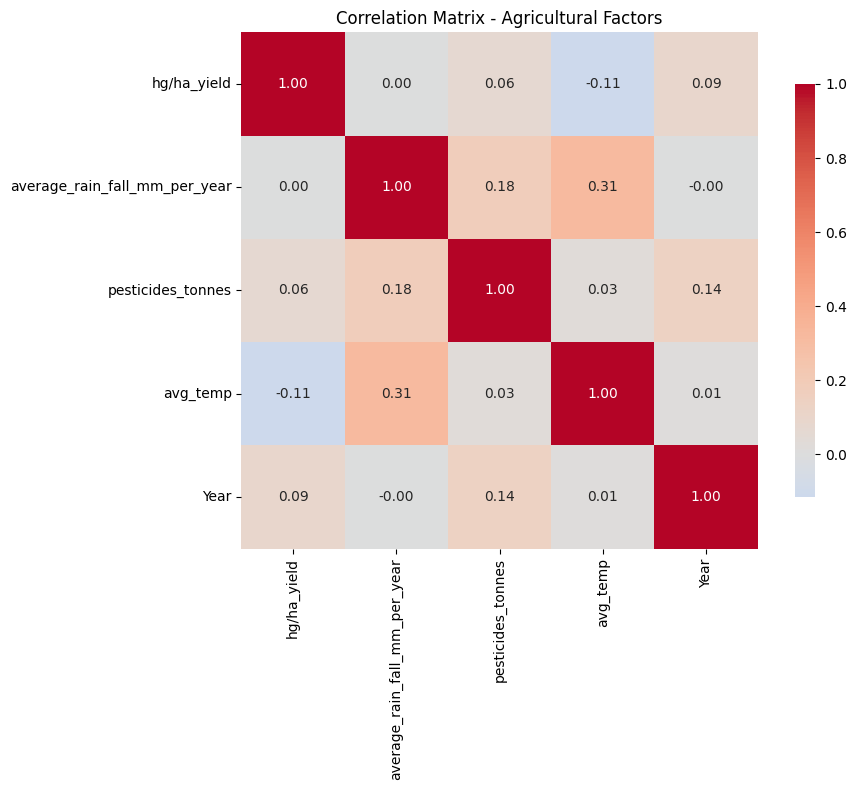


Correlations with Crop Yield:
  Year: 0.092
  pesticides_tonnes: 0.064
  average_rain_fall_mm_per_year: 0.001
  avg_temp: -0.115


In [ ]:
def correlation_analysis(df):
    """Analyze relationships between variables"""
    
    print("\n🔗 CORRELATION ANALYSIS")
    print("="*40)
    
    # Select numerical columns
    numerical_cols = ['hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp', 'Year']
    numerical_df = df[numerical_cols]
    
    # Correlation matrix
    corr_matrix = numerical_df.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
    plt.title('Correlation Matrix - Agricultural Factors')
    plt.tight_layout()
    plt.show()
    
    # Print strongest correlations with yield
    yield_correlations = corr_matrix['hg/ha_yield'].sort_values(ascending=False)
    print("\nCorrelations with Crop Yield:")
    for factor, correlation in yield_correlations.items():
        if factor != 'hg/ha_yield':
            print(f"  {factor}: {correlation:.3f}")

correlation_analysis(master_df)